In [1]:
!conda install pandas seaborn -y

Solving environment: done

# All requested packages already installed.



In [2]:
!pip install opencv-python torchsummary scikit-learn torchviz utils imageio

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import utils
import time
from torch.nn.functional import one_hot
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86'] cuda


In [5]:
from __future__ import print_function
import argparse
import datetime
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
import gc
import matplotlib.colors as mat_color
import numpy as np
from PIL import Image
import random
import cv2
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from torchviz import make_dot
import imageio
from torchvision import datasets, transforms

In [6]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

class Generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32, class_num=10):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.class_num, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

    
class Discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32, class_num=10):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
        )
        self.dc = nn.Sequential(
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        self.cl = nn.Sequential(
            nn.Linear(1024, self.class_num),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc1(x)
        d = self.dc(x)
        c = self.cl(x)

        return d, c


In [7]:
def generate_animation(path, num):
    images = []
    for e in range(num):
        img_name = path + '_generate_animation_epoch%03d' % (e+1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(path + '_generate_animation.gif', images, fps=5)

def loss_plot(hist, path='Train_hist', model_name = ''):
    x = range(len(hist['D_losses']))

    plt.plot(x, hist['D_losses'], label='D_losses')
    plt.plot(x, hist['G_losses'], label='G_losses')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')
    plt.savefig(path)
    plt.close()

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))
    print("image saved at ->", path)
    return imageio.imwrite(path, image)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

In [8]:
class ACGAN(object):
    def __init__(self):
        self.model_name = 'ACGAN'
        self.I_want_to_train_faster = 10
        self.num_epoch = round(1000/self.I_want_to_train_faster)
        self.base_path = './data'
        self.base_folder = "Covid-19 Image Dataset"
        self.classic_folder = 'Coivd-19_Classic'
        self.synthetic_folder = 'Coivd-19_Synthetic'
        self.data_dir = os.path.join(self.base_path, self.classic_folder)
        self.batch_size = 128
        self.train_path = os.path.join(self.data_dir, "train")
        self.test_path = os.path.join(self.data_dir, "test")
        self.labels = os.listdir(self.train_path)
        self.no_norm = mat_color.Normalize(vmin=0, vmax=255, clip=False)
        self.label_dict = {
            i : self.labels[i]
            for i in range(len(self.labels))
        }
        self.img_size = 128 * 2
        self.num_of_ch = 3
        # size of z latent vector (i.e. size of generator input)
        self.size_of_z = self.img_size
        self.num_of_label = len(self.labels)
        self.sample_num = self.num_of_label ** 2
        self.learning_rate_g = 0.00000002 * self.I_want_to_train_faster
        self.learning_rate_d = 0.00000002 * self.I_want_to_train_faster
        # beta1 hyperparam for adam
        self.adam_beta_1 = 0.5
        # beta2 hyperparam for adam
        self.adam_beta_2 = 0.999
        self.real_label = 1.0
        self.fake_label = 0.0
        self.syn_criterion = nn.BCELoss().to(device) # synthesizing
        self.class_criterion = nn.CrossEntropyLoss().to(device) # classification
        
        self.train_loader, self.test_loader, self.train_data, self.test_data = self.load_dataset()
        self.generator = Generator(input_dim=self.size_of_z, 
                                   output_dim=self.num_of_ch, 
                                   input_size=self.img_size, 
                                   class_num=self.num_of_label).to(device)
        self.discriminator = Discriminator(input_dim=self.num_of_ch, 
                                           output_dim=1, 
                                           input_size=self.img_size, 
                                           class_num=self.num_of_label).to(device)

        self.optimizer_d = optim.Adam(self.discriminator.parameters(), 
                                      lr=self.learning_rate_d, 
                                      betas=(self.adam_beta_1, self.adam_beta_2))
        self.optimizer_g = optim.Adam(self.generator.parameters(), 
                                      lr=self.learning_rate_g, 
                                      betas=(self.adam_beta_1, self.adam_beta_2))

        # fixed noise & label
        self.sample_z_fixed = torch.zeros((self.sample_num, self.size_of_z))
        for i in range(self.num_of_label):
            self.sample_z_fixed[i*self.num_of_label] = torch.rand(1, self.size_of_z)
            for j in range(1, self.num_of_label):
                self.sample_z_fixed[i*self.num_of_label + j] = self.sample_z_fixed[i*self.num_of_label]

        temp = torch.zeros((self.num_of_label, 1))
        for i in range(self.num_of_label):
            temp[i, 0] = i

        temp_y = torch.zeros((self.sample_num, 1))
        for i in range(self.num_of_label):
            temp_y[i*self.num_of_label: (i+1)*self.num_of_label] = temp

        self.sample_y_fixed = torch.zeros((self.sample_num, self.num_of_label)).scatter_(1, temp_y.type(torch.LongTensor), 1)
        self.sample_z_fixed, self.sample_y_fixed = self.sample_z_fixed.to(device), self.sample_y_fixed.to(device)
        
    def load_dataset(self):
        train_dir = self.train_path
        test_dir = self.test_path
        transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        train_data = datasets.ImageFolder(train_dir, transform=transform)
        train_loader = DataLoader(train_data, self.batch_size, shuffle=True, num_workers=1)

        test_data = datasets.ImageFolder(test_dir ,transform=transform)
        test_loader = DataLoader(test_data, self.batch_size, shuffle=True, num_workers=1)

        return train_loader, test_loader, train_data, test_data

    def modeltorchviz(model, input_1, input_2):
        if input_2 != None:
            y = model(input_1.to(device), input_2.to(device))
        else:
            y = model(input_1to(device))
        if input_2 != None:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)] + [('x', input_2)]))
        else:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)]))
        MyConvNetVis.format = "png"
        MyConvNetVis.directory = "images"
        MyConvNetVis.view() 
    
    def visualize_results(self, epoch, fix=True):
        self.generator.eval()

        image_frame_dim = round(np.sqrt(self.sample_num))
        if fix:
            """ fixed noise """
            samples = self.generator(self.sample_z_fixed, self.sample_y_fixed)
        else:
            """ random noise """
            sample_y_ = torch.zeros(self.batch_size, self.class_num).scatter_(1, torch.randint(0, self.class_num - 1, (self.batch_size, 1)).type(torch.LongTensor), 1)
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            sample_z_, sample_y_ = sample_z_.cuda(), sample_y_.cuda()
            samples = self.generator(sample_z_, sample_y_)

        samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                    os.path.join('.', 'GANAug/plots/ACGAN') + "/" + self.model_name + '_generate_animation_epoch%03d' % epoch + '.png')
    
    def train(self):
        for func in [
            lambda: os.mkdir(os.path.join('.', 'GANAug')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/model')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/plots')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/model/ACGAN')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/plots/ACGAN')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN/' + self.label_dict[0])),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN/' + self.label_dict[1])),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN/' + self.label_dict[2]))]:
            try:
                func()
            except Exception as error:
                print(error)
                continue
        matrix_fields = [
            'G_losses',
            'G_class_losses',
            'G_syn_losses',
            'D_losses',
            'D_real_losses',
            'D_fake_losses',
            'D_class_losses',
            'D_syn_losses',
            'Losses',
            'Time_per_epoch',
            'Total_time'
        ]
        self.metrics = {field: list() for field in matrix_fields}
        early_stop_count = 0
        early_stop_patient = len(self.train_loader) * 42
        early_stop = False
        best_batch_loss = -1
        save_model = False
        number_of_model_saved = 10
        label_fixed_data = [0, 1, 2, 0, 1, 2, 0, 1, 2]
        
        def get_file_list(file_path, length):
            dir_list = os.listdir(file_path)
            dir_list = only_pth_file(dir_list)
            if not dir_list:
                return
            else:
                dir_list = sorted(dir_list,  key=lambda x: os.path.getmtime(os.path.join(file_path, x)))
                print("files to be deleted < length =", length ,"> ->", dir_list[0:length])
                return dir_list[0:length]

        def only_pth_file(file_list):
            new_list = []
            for file in file_list:
                if file[-4:] == ".pth":
                    new_list.append(file)
            return new_list
            
        start_time = time.time()
        print("Start Testing ...")
        print(self.generator)
        print(self.discriminator)
        summary(self.generator, [[self.size_of_z], [self.num_of_label]], batch_size=self.batch_size, device=device)
        summary(self.discriminator, (self.num_of_ch, self.img_size, self.img_size), batch_size=self.batch_size, device=device)
        g_output = self.generator(torch.rand((self.batch_size, self.size_of_z)).to(device), 
                                  torch.ones((self.batch_size, self.num_of_label)).to(device))
        print(g_output.shape)
        s_output, c_output = self.discriminator(torch.rand(g_output.shape).to(device))
        print(s_output.shape)
        print(c_output.shape)
        del g_output, s_output, c_output
        print("Testing Done in ->", time.time() - start_time)
        start_time = time.time()
        print("Start Training ...")

        self.discriminator.train()
        for epoch in range(self.num_epoch):
            epoch += 1
            log_in_data_loader = []
            self.generator.train()
            epoch_start_time = time.time()
            for i, data in enumerate(tqdm(self.train_loader, 0)):
                x_, y_ = data
                batch_size_x_ = x_.size(0)
                z_ = torch.rand((batch_size_x_, self.size_of_z))
                y_vec_ = torch.zeros((batch_size_x_, self.num_of_label)).scatter_(1, y_.type(torch.LongTensor).unsqueeze(1), 1)
                x_, z_, y_vec_ = x_.cuda(), z_.cuda(), y_vec_.cuda()
                self.y_real_, self.y_fake_ = torch.ones(batch_size_x_, 1), torch.zeros(batch_size_x_, 1)
                self.y_real_, self.y_fake_ = self.y_real_.to(device), self.y_fake_.to(device)
        
                # update D network
                self.optimizer_d.zero_grad()

                D_real, C_real = self.discriminator(x_)
                D_real_loss = self.syn_criterion(D_real, self.y_real_)
                C_real_loss = self.class_criterion(C_real, torch.max(y_vec_, 1)[1])

                G_ = self.generator(z_, y_vec_)
                D_fake, C_fake = self.discriminator(G_)
                D_fake_loss = self.syn_criterion(D_fake, self.y_fake_)
                C_fake_loss = self.class_criterion(C_fake, torch.max(y_vec_, 1)[1])

                D_loss = D_real_loss + C_real_loss + D_fake_loss + C_fake_loss
                self.metrics['D_losses'].append(D_loss.item())
                self.metrics['D_real_losses'].append((D_real_loss + C_real_loss).item())
                self.metrics['D_fake_losses'].append((D_fake_loss + C_fake_loss).item())
                self.metrics['D_class_losses'].append((C_real_loss + C_fake_loss).item())
                self.metrics['D_syn_losses'].append((D_real_loss + D_fake_loss).item())

                D_loss.backward()
                self.optimizer_d.step()

                # update G network
                self.optimizer_g.zero_grad()

                G_ = self.generator(z_, y_vec_)
                D_fake, C_fake = self.discriminator(G_)

                D_fake_loss = self.syn_criterion(D_fake, self.y_real_)
                C_fake_loss = self.class_criterion(C_fake, torch.max(y_vec_, 1)[1])

                G_loss = D_fake_loss + C_fake_loss
                self.metrics['G_losses'].append(G_loss.item())
                self.metrics['G_syn_losses'].append(D_fake_loss.item())
                self.metrics['G_class_losses'].append(C_fake_loss.item())
                self.metrics['Losses'].append(self.metrics['G_losses'][-1] + self.metrics['D_losses'][-1])

                G_loss.backward()
                self.optimizer_g.step()

                if best_batch_loss < 0:
                    best_batch_loss = self.metrics['Losses'][-1]
                    early_stop_count = 0
                else:
                    if best_batch_loss >= self.metrics['Losses'][-1]:
                        best_batch_loss = self.metrics['Losses'][-1]
                        early_stop_count = 0
                        log_in_data_loader.append("---------------------<lowest loss update -> " + str(best_batch_loss) + " at -> " + str(i + 1) + ">---------------------")
                        save_model = True
                    else:
                        early_stop_count += 1
                        if early_stop_count >= early_stop_patient:
                            log_in_data_loader.append("-----------------------------------< early stopping ... >-----------------------------------")
                            early_stop = True

                if i % round(len(self.train_loader)/5) == 0:
                    vutils.save_image(x_, './GANAug/output_images/ACGAN/real_samples_e' + str(epoch) + '_d' + str(i) + '.jpg', normalize=True)
                    fake = self.generator(self.sample_z_fixed, self.sample_y_fixed)
                    for j in range(len(fake)):
                        vutils.save_image(fake[j].data,
                                '%s/fake_samples_epoch_%03d.jpg' % ('./GANAug/output_images/ACGAN/' + self.label_dict[label_fixed_data[j]], epoch), 
                                          normalize=True)

            self.metrics['Time_per_epoch'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results(epoch)
    
            for message in log_in_data_loader:
                print(message)
            print('[%d/%d] ======================================================================== \nLoss_D: %.8f, Loss_G: %.8f\nLoss_S_D: %.8f, Loss_C_D: %.8f, Loss_R_D: %.8f, Loss_F_D: %.8f\nLoss_S_G: %.8f, Loss_C_G: %.8f'
                  % (epoch, self.num_epoch, 
                     np.mean(self.metrics['D_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['G_losses'][-len(self.train_loader):]),
                     np.mean(self.metrics['D_syn_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_class_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_real_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_fake_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['G_syn_losses'][-len(self.train_loader):]),
                     np.mean(self.metrics['G_class_losses'][-len(self.train_loader):])))

            # do checkpointing
            if save_model == True:
                save_model = False
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d_save_model.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d_save_model.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
            elif early_stop:
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d_early_stop.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d_early_stop.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
                break
            elif epoch % round(self.num_epoch/10) == 0:
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
            else:
                print("---------------------< no model saved at epoch:", epoch, ">---------------------")

            if len(only_pth_file(os.listdir(os.path.join('.', 'GANAug/model/ACGAN')))) > number_of_model_saved:
                delete_list = get_file_list(os.path.join('.', 'GANAug/model/ACGAN'), 
                                            len(only_pth_file(os.listdir(os.path.join('.', 'GANAug/model/ACGAN')))) - number_of_model_saved)
                for file in delete_list:
                    if os.path.exists(os.path.join(os.path.join('.', 'GANAug/model/ACGAN'), file)):
                        os.remove(os.path.join(os.path.join('.', 'GANAug/model/ACGAN'), file))
                    else:
                        print("file ->", os.path.join(os.path.join('.', 'GANAug/model/ACGAN'), file), "does not exist")

        self.metrics['Total_time'].append(time.time() - start_time)
        print("Average epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.metrics['Time_per_epoch']),
                                                                        self.num_epoch, self.metrics['Total_time'][0]))
        generate_animation(os.path.join('.', 'GANAug/plots/ACGAN/') + self.model_name, self.num_epoch)
        loss_plot(self.metrics, os.path.join('.', 'GANAug/plots/ACGAN/'), self.model_name + "_loss_plot")
        print("Training Done !")

In [9]:
acgan = ACGAN()

In [10]:
acgan.train()

Start Testing ...
Generator(
  (fc): Sequential(
    (0): Linear(in_features=259, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=524288, bias=True)
    (4): BatchNorm1d(524288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:49<00:00,  4.79s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch001.png
---------------------<lowest loss update -> 5.610332250595093 at -> 6>---------------------
---------------------<lowest loss update -> 5.600549340248108 at -> 12>---------------------
---------------------<lowest loss update -> 5.541020393371582 at -> 16>---------------------
---------------------<lowest loss update -> 5.409577012062073 at -> 20>---------------------
---------------------<lowest loss update -> 5.408818244934082 at -> 22>---------------------
---------------------<lowest loss update -> 5.401102900505066 at -> 25>---------------------
---------------------<lowest loss update -> 5.385303974151611 at -> 26>---------------------
---------------------<lowest loss update -> 5.329936265945435 at -> 29>---------------------
---------------------<lowest loss update -> 5.32903790473938 at -> 34>---------------------
---------------------<lowest loss update -> 5.215855121612549 at -> 35>-----------------

100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:49<00:00,  4.77s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch002.png
[2/100] ======================================================================== 
Loss_D: 3.28082192, Loss_G: 1.75694314
Loss_S_D: 1.42250312, Loss_C_D: 1.85831880, Loss_R_D: 1.56667368, Loss_F_D: 1.71414823
Loss_S_G: 0.73715336, Loss_C_G: 1.01978978
---------------------< no model saved at epoch: 2 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:49<00:00,  4.79s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch003.png
---------------------<lowest loss update -> 4.6014392375946045 at -> 12>---------------------
---------------------<lowest loss update -> 4.593933820724487 at -> 27>---------------------
---------------------<lowest loss update -> 4.5521240234375 at -> 28>---------------------
---------------------<lowest loss update -> 4.527731418609619 at -> 37>---------------------
---------------------<lowest loss update -> 4.47741961479187 at -> 38>---------------------
---------------------<lowest loss update -> 4.456029891967773 at -> 42>---------------------
---------------------<lowest loss update -> 4.414335250854492 at -> 44>---------------------
---------------------<lowest loss update -> 4.190391540527344 at -> 48>---------------------
[3/100] ======================================================================== 
Loss_D: 3.02861058, Loss_G: 1.65090254
Loss_S_D: 1.42004453, Loss_C_D: 1.60856604, Loss_R_D: 1.4202

100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:48<00:00,  4.75s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch004.png
[4/100] ======================================================================== 
Loss_D: 2.85470596, Loss_G: 1.56368249
Loss_S_D: 1.41780814, Loss_C_D: 1.43689784, Loss_R_D: 1.33211256, Loss_F_D: 1.52259341
Loss_S_G: 0.73535654, Loss_C_G: 0.82832595
---------------------< no model saved at epoch: 4 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:51<00:00,  4.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch005.png
---------------------<lowest loss update -> 4.120802402496338 at -> 12>---------------------
---------------------<lowest loss update -> 4.0408512353897095 at -> 19>---------------------
---------------------<lowest loss update -> 4.003730535507202 at -> 38>---------------------
---------------------<lowest loss update -> 3.998887538909912 at -> 46>---------------------
[5/100] ======================================================================== 
Loss_D: 2.71494404, Loss_G: 1.48843929
Loss_S_D: 1.41482439, Loss_C_D: 1.30011964, Loss_R_D: 1.26760446, Loss_F_D: 1.44733958
Loss_S_G: 0.73473400, Loss_C_G: 0.75370530


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:47<00:00,  4.75s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch006.png
---------------------<lowest loss update -> 3.959895610809326 at -> 5>---------------------
---------------------<lowest loss update -> 3.94734787940979 at -> 7>---------------------
---------------------<lowest loss update -> 3.9356255531311035 at -> 25>---------------------
---------------------<lowest loss update -> 3.9157010316848755 at -> 33>---------------------
---------------------<lowest loss update -> 3.8902714252471924 at -> 40>---------------------
---------------------<lowest loss update -> 3.8860808610916138 at -> 45>---------------------
[6/100] ======================================================================== 
Loss_D: 2.60643719, Loss_G: 1.42128143
Loss_S_D: 1.41451113, Loss_C_D: 1.19192606, Loss_R_D: 1.22363725, Loss_F_D: 1.38279994
Loss_S_G: 0.73352231, Loss_C_G: 0.68775912


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:48<00:00,  4.77s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch007.png
---------------------<lowest loss update -> 3.813560724258423 at -> 3>---------------------
---------------------<lowest loss update -> 3.812271237373352 at -> 5>---------------------
---------------------<lowest loss update -> 3.8020204305648804 at -> 15>---------------------
---------------------<lowest loss update -> 3.778324604034424 at -> 19>---------------------
---------------------<lowest loss update -> 3.768249273300171 at -> 30>---------------------
---------------------<lowest loss update -> 3.7223507165908813 at -> 35>---------------------
---------------------<lowest loss update -> 3.7109789848327637 at -> 44>---------------------
---------------------<lowest loss update -> 3.6891565322875977 at -> 47>---------------------
[7/100] ======================================================================== 
Loss_D: 2.49983344, Loss_G: 1.35605225
Loss_S_D: 1.41183361, Loss_C_D: 1.08799982, Loss_R_D: 1.

100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:50<00:00,  4.80s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch008.png
---------------------<lowest loss update -> 3.683218240737915 at -> 2>---------------------
---------------------<lowest loss update -> 3.6650915145874023 at -> 3>---------------------
---------------------<lowest loss update -> 3.548032760620117 at -> 16>---------------------
---------------------<lowest loss update -> 3.5436835289001465 at -> 25>---------------------
---------------------<lowest loss update -> 3.5255616903305054 at -> 40>---------------------
---------------------<lowest loss update -> 3.464813232421875 at -> 48>---------------------
[8/100] ======================================================================== 
Loss_D: 2.40931215, Loss_G: 1.29383518
Loss_S_D: 1.41045838, Loss_C_D: 0.99885377, Loss_R_D: 1.15180996, Loss_F_D: 1.25750221
Loss_S_G: 0.73115637, Loss_C_G: 0.56267881
files to be deleted < length = 2 > -> ['G_epoch_1_save_model.pth', 'D_epoch_1_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:48<00:00,  4.75s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch009.png
---------------------<lowest loss update -> 3.457379937171936 at -> 29>---------------------
---------------------<lowest loss update -> 3.4467661380767822 at -> 35>---------------------
---------------------<lowest loss update -> 3.4163782596588135 at -> 37>---------------------
[9/100] ======================================================================== 
Loss_D: 2.33563758, Loss_G: 1.24656624
Loss_S_D: 1.40851011, Loss_C_D: 0.92712748, Loss_R_D: 1.12500272, Loss_F_D: 1.21063487
Loss_S_G: 0.73075920, Loss_C_G: 0.51580704
files to be deleted < length = 2 > -> ['G_epoch_3_save_model.pth', 'D_epoch_3_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:47<00:00,  4.75s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch010.png
---------------------<lowest loss update -> 3.3913393020629883 at -> 31>---------------------
---------------------<lowest loss update -> 3.367894172668457 at -> 33>---------------------
---------------------<lowest loss update -> 3.340784788131714 at -> 37>---------------------
---------------------<lowest loss update -> 3.3285235166549683 at -> 39>---------------------
---------------------<lowest loss update -> 3.233696937561035 at -> 44>---------------------
[10/100] ======================================================================== 
Loss_D: 2.26789091, Loss_G: 1.20277182
Loss_S_D: 1.40562700, Loss_C_D: 0.86226392, Loss_R_D: 1.10125540, Loss_F_D: 1.16663550
Loss_S_G: 0.72969882, Loss_C_G: 0.47307300
files to be deleted < length = 2 > -> ['G_epoch_5_save_model.pth', 'D_epoch_5_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:49<00:00,  4.79s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch011.png
---------------------<lowest loss update -> 3.2177042961120605 at -> 26>---------------------
[11/100] ======================================================================== 
Loss_D: 2.20980088, Loss_G: 1.16539681
Loss_S_D: 1.40547924, Loss_C_D: 0.80432165, Loss_R_D: 1.07914162, Loss_F_D: 1.13065927
Loss_S_G: 0.73049036, Loss_C_G: 0.43490645
files to be deleted < length = 2 > -> ['G_epoch_6_save_model.pth', 'D_epoch_6_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch012.png
---------------------<lowest loss update -> 3.2009832859039307 at -> 19>---------------------
---------------------<lowest loss update -> 3.197669744491577 at -> 29>---------------------
---------------------<lowest loss update -> 3.1972646713256836 at -> 33>---------------------
---------------------<lowest loss update -> 3.1927826404571533 at -> 37>---------------------
---------------------<lowest loss update -> 3.1146528720855713 at -> 38>---------------------
[12/100] ======================================================================== 
Loss_D: 2.15557954, Loss_G: 1.13012506
Loss_S_D: 1.40328914, Loss_C_D: 0.75229039, Loss_R_D: 1.05894268, Loss_F_D: 1.09663686
Loss_S_G: 0.72840754, Loss_C_G: 0.40171750
files to be deleted < length = 2 > -> ['G_epoch_7_save_model.pth', 'D_epoch_7_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:50<00:00,  4.79s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch013.png
---------------------<lowest loss update -> 3.1045491695404053 at -> 20>---------------------
---------------------<lowest loss update -> 3.0774301290512085 at -> 35>---------------------
[13/100] ======================================================================== 
Loss_D: 2.12096839, Loss_G: 1.10380013
Loss_S_D: 1.40106746, Loss_C_D: 0.71990096, Loss_R_D: 1.04986493, Loss_F_D: 1.07110346
Loss_S_G: 0.72793830, Loss_C_G: 0.37586182
files to be deleted < length = 2 > -> ['G_epoch_8_save_model.pth', 'D_epoch_8_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:48<00:00,  4.76s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch014.png
---------------------<lowest loss update -> 3.071032762527466 at -> 11>---------------------
---------------------<lowest loss update -> 3.068026304244995 at -> 12>---------------------
---------------------<lowest loss update -> 3.066080689430237 at -> 18>---------------------
---------------------<lowest loss update -> 3.02515709400177 at -> 24>---------------------
[14/100] ======================================================================== 
Loss_D: 2.07640622, Loss_G: 1.07480823
Loss_S_D: 1.40017749, Loss_C_D: 0.67622872, Loss_R_D: 1.03417776, Loss_F_D: 1.04222845
Loss_S_G: 0.72791704, Loss_C_G: 0.34689119
files to be deleted < length = 2 > -> ['G_epoch_9_save_model.pth', 'D_epoch_9_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:47<00:00,  4.75s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch015.png
---------------------<lowest loss update -> 2.979858875274658 at -> 11>---------------------
[15/100] ======================================================================== 
Loss_D: 2.03575330, Loss_G: 1.04903407
Loss_S_D: 1.39791563, Loss_C_D: 0.63783767, Loss_R_D: 1.01817740, Loss_F_D: 1.01757588
Loss_S_G: 0.72671135, Loss_C_G: 0.32232272
files to be deleted < length = 2 > -> ['G_epoch_10_save_model.pth', 'D_epoch_10_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:46<00:00,  4.73s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch016.png
---------------------<lowest loss update -> 2.942429542541504 at -> 8>---------------------
---------------------<lowest loss update -> 2.9352047443389893 at -> 37>---------------------
[16/100] ======================================================================== 
Loss_D: 2.01004758, Loss_G: 1.02731409
Loss_S_D: 1.39713318, Loss_C_D: 0.61291439, Loss_R_D: 1.01242098, Loss_F_D: 0.99762659
Loss_S_G: 0.72555015, Loss_C_G: 0.30176394
files to be deleted < length = 2 > -> ['G_epoch_11_save_model.pth', 'D_epoch_11_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:47<00:00,  4.74s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch017.png
---------------------<lowest loss update -> 2.9135013818740845 at -> 7>---------------------
---------------------<lowest loss update -> 2.9090349078178406 at -> 8>---------------------
---------------------<lowest loss update -> 2.8913758993148804 at -> 32>---------------------
---------------------<lowest loss update -> 2.881327748298645 at -> 33>---------------------
---------------------<lowest loss update -> 2.8561418056488037 at -> 38>---------------------
[17/100] ======================================================================== 
Loss_D: 1.98033165, Loss_G: 1.00729740
Loss_S_D: 1.39511581, Loss_C_D: 0.58521583, Loss_R_D: 1.00250052, Loss_F_D: 0.97783111
Loss_S_G: 0.72488514, Loss_C_G: 0.28241227
files to be deleted < length = 2 > -> ['G_epoch_12_save_model.pth', 'D_epoch_12_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:49<00:00,  4.78s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch018.png
---------------------<lowest loss update -> 2.8507556915283203 at -> 6>---------------------
---------------------<lowest loss update -> 2.8231608867645264 at -> 9>---------------------
---------------------<lowest loss update -> 2.82269549369812 at -> 15>---------------------
---------------------<lowest loss update -> 2.8212618231773376 at -> 21>---------------------
---------------------<lowest loss update -> 2.819972574710846 at -> 29>---------------------
---------------------<lowest loss update -> 2.8152530193328857 at -> 36>---------------------
[18/100] ======================================================================== 
Loss_D: 1.94737988, Loss_G: 0.98629071
Loss_S_D: 1.39275487, Loss_C_D: 0.55462501, Loss_R_D: 0.99045697, Loss_F_D: 0.95692292
Loss_S_G: 0.72453168, Loss_C_G: 0.26175904
files to be deleted < length = 2 > -> ['G_epoch_13_save_model.pth', 'D_epoch_13_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:47<00:00,  4.75s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch019.png
---------------------<lowest loss update -> 2.774206221103668 at -> 8>---------------------
---------------------<lowest loss update -> 2.7628917694091797 at -> 43>---------------------
[19/100] ======================================================================== 
Loss_D: 1.92225352, Loss_G: 0.97204420
Loss_S_D: 1.39162664, Loss_C_D: 0.53062688, Loss_R_D: 0.97916808, Loss_F_D: 0.94308543
Loss_S_G: 0.72449251, Loss_C_G: 0.24755169
files to be deleted < length = 2 > -> ['G_epoch_14_save_model.pth', 'D_epoch_14_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:51<00:00,  4.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch020.png
---------------------<lowest loss update -> 2.739266574382782 at -> 14>---------------------
[20/100] ======================================================================== 
Loss_D: 1.89792877, Loss_G: 0.95783894
Loss_S_D: 1.38926933, Loss_C_D: 0.50865944, Loss_R_D: 0.96981271, Loss_F_D: 0.92811606
Loss_S_G: 0.72405258, Loss_C_G: 0.23378637
files to be deleted < length = 2 > -> ['G_epoch_15_save_model.pth', 'D_epoch_15_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:49<00:00,  4.79s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch021.png
---------------------<lowest loss update -> 2.724622964859009 at -> 25>---------------------
---------------------<lowest loss update -> 2.6910476088523865 at -> 37>---------------------
[21/100] ======================================================================== 
Loss_D: 1.87712620, Loss_G: 0.94536341
Loss_S_D: 1.38712359, Loss_C_D: 0.49000262, Loss_R_D: 0.96080924, Loss_F_D: 0.91631696
Loss_S_G: 0.72349218, Loss_C_G: 0.22187123
files to be deleted < length = 2 > -> ['G_epoch_16_save_model.pth', 'D_epoch_16_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch022.png
---------------------<lowest loss update -> 2.667408585548401 at -> 7>---------------------
[22/100] ======================================================================== 
Loss_D: 1.86352773, Loss_G: 0.93680649
Loss_S_D: 1.38677050, Loss_C_D: 0.47675724, Loss_R_D: 0.95503258, Loss_F_D: 0.90849515
Loss_S_G: 0.72373203, Loss_C_G: 0.21307446
files to be deleted < length = 2 > -> ['G_epoch_17_save_model.pth', 'D_epoch_17_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:50<00:00,  4.79s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch023.png
---------------------<lowest loss update -> 2.6555556058883667 at -> 28>---------------------
---------------------<lowest loss update -> 2.4531575441360474 at -> 48>---------------------
[23/100] ======================================================================== 
Loss_D: 1.82506711, Loss_G: 0.91520833
Loss_S_D: 1.38365454, Loss_C_D: 0.44141257, Loss_R_D: 0.93961476, Loss_F_D: 0.88545235
Loss_S_G: 0.72360386, Loss_C_G: 0.19160447
files to be deleted < length = 2 > -> ['G_epoch_18_save_model.pth', 'D_epoch_18_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:53<00:00,  4.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch024.png
[24/100] ======================================================================== 
Loss_D: 1.82543190, Loss_G: 0.90988160
Loss_S_D: 1.38290521, Loss_C_D: 0.44252670, Loss_R_D: 0.94373176, Loss_F_D: 0.88170015
Loss_S_G: 0.72266320, Loss_C_G: 0.18721840
---------------------< no model saved at epoch: 24 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:51<00:00,  4.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch025.png
[25/100] ======================================================================== 
Loss_D: 1.79148925, Loss_G: 0.89563725
Loss_S_D: 1.38130952, Loss_C_D: 0.41017973, Loss_R_D: 0.92499835, Loss_F_D: 0.86649091
Loss_S_G: 0.72352443, Loss_C_G: 0.17211282
---------------------< no model saved at epoch: 25 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:51<00:00,  4.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch026.png
[26/100] ======================================================================== 
Loss_D: 1.78588962, Loss_G: 0.88982517
Loss_S_D: 1.37887233, Loss_C_D: 0.40701730, Loss_R_D: 0.92533286, Loss_F_D: 0.86055678
Loss_S_G: 0.72234735, Loss_C_G: 0.16747782
---------------------< no model saved at epoch: 26 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:55<00:00,  4.90s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch027.png
[27/100] ======================================================================== 
Loss_D: 1.77734873, Loss_G: 0.88645298
Loss_S_D: 1.37947399, Loss_C_D: 0.39787475, Loss_R_D: 0.91931533, Loss_F_D: 0.85803340
Loss_S_G: 0.72319388, Loss_C_G: 0.16325910
---------------------< no model saved at epoch: 27 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch028.png
---------------------<lowest loss update -> 2.403590679168701 at -> 48>---------------------
[28/100] ======================================================================== 
Loss_D: 1.75150601, Loss_G: 0.87181204
Loss_S_D: 1.37645608, Loss_C_D: 0.37504992, Loss_R_D: 0.90877715, Loss_F_D: 0.84272886
Loss_S_G: 0.72252222, Loss_C_G: 0.14928982
files to be deleted < length = 2 > -> ['G_epoch_19_save_model.pth', 'D_epoch_19_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:56<00:00,  4.92s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch029.png
[29/100] ======================================================================== 
Loss_D: 1.74224953, Loss_G: 0.86702506
Loss_S_D: 1.37539442, Loss_C_D: 0.36685509, Loss_R_D: 0.90395679, Loss_F_D: 0.83829273
Loss_S_G: 0.72217626, Loss_C_G: 0.14484880
---------------------< no model saved at epoch: 29 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:57<00:00,  4.96s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch030.png
[30/100] ======================================================================== 
Loss_D: 1.74516412, Loss_G: 0.86879813
Loss_S_D: 1.37386358, Loss_C_D: 0.37130057, Loss_R_D: 0.90587626, Loss_F_D: 0.83928787
Loss_S_G: 0.72252840, Loss_C_G: 0.14626973
files to be deleted < length = 2 > -> ['G_epoch_20_save_model.pth', 'D_epoch_20_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:59<00:00,  4.98s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch031.png
[31/100] ======================================================================== 
Loss_D: 1.72759649, Loss_G: 0.85632824
Loss_S_D: 1.37286668, Loss_C_D: 0.35472982, Loss_R_D: 0.89982223, Loss_F_D: 0.82777426
Loss_S_G: 0.72172226, Loss_C_G: 0.13460598
---------------------< no model saved at epoch: 31 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch032.png
[32/100] ======================================================================== 
Loss_D: 1.71527466, Loss_G: 0.85244681
Loss_S_D: 1.37132163, Loss_C_D: 0.34395303, Loss_R_D: 0.89296771, Loss_F_D: 0.82230695
Loss_S_G: 0.72291680, Loss_C_G: 0.12953001
---------------------< no model saved at epoch: 32 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch033.png
---------------------<lowest loss update -> 2.3636131286621094 at -> 48>---------------------
[33/100] ======================================================================== 
Loss_D: 1.69341626, Loss_G: 0.84554181
Loss_S_D: 1.36856975, Loss_C_D: 0.32484652, Loss_R_D: 0.87967752, Loss_F_D: 0.81373875
Loss_S_G: 0.72323864, Loss_C_G: 0.12230317
files to be deleted < length = 2 > -> ['G_epoch_21_save_model.pth', 'D_epoch_21_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch034.png
[34/100] ======================================================================== 
Loss_D: 1.68993198, Loss_G: 0.84075925
Loss_S_D: 1.36764930, Loss_C_D: 0.32228267, Loss_R_D: 0.88014210, Loss_F_D: 0.80978988
Loss_S_G: 0.72258301, Loss_C_G: 0.11817624
---------------------< no model saved at epoch: 34 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.85s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch035.png
[35/100] ======================================================================== 
Loss_D: 1.67777590, Loss_G: 0.83604962
Loss_S_D: 1.36607028, Loss_C_D: 0.31170560, Loss_R_D: 0.87285119, Loss_F_D: 0.80492471
Loss_S_G: 0.72284540, Loss_C_G: 0.11320422
---------------------< no model saved at epoch: 35 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:57<00:00,  4.96s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch036.png
[36/100] ======================================================================== 
Loss_D: 1.66791288, Loss_G: 0.83305797
Loss_S_D: 1.36451750, Loss_C_D: 0.30339539, Loss_R_D: 0.86737027, Loss_F_D: 0.80054262
Loss_S_G: 0.72347486, Loss_C_G: 0.10958311
---------------------< no model saved at epoch: 36 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:53<00:00,  4.87s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch037.png
[37/100] ======================================================================== 
Loss_D: 1.66602870, Loss_G: 0.82844132
Loss_S_D: 1.36389272, Loss_C_D: 0.30213598, Loss_R_D: 0.86959085, Loss_F_D: 0.79643784
Loss_S_G: 0.72304262, Loss_C_G: 0.10539870
---------------------< no model saved at epoch: 37 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch038.png
[38/100] ======================================================================== 
Loss_D: 1.66970876, Loss_G: 0.83149326
Loss_S_D: 1.36130251, Loss_C_D: 0.30840625, Loss_R_D: 0.87280874, Loss_F_D: 0.79690001
Loss_S_G: 0.72410162, Loss_C_G: 0.10739164
---------------------< no model saved at epoch: 38 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:57<00:00,  4.95s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch039.png
[39/100] ======================================================================== 
Loss_D: 1.64873856, Loss_G: 0.82457710
Loss_S_D: 1.36037929, Loss_C_D: 0.28835926, Loss_R_D: 0.85893973, Loss_F_D: 0.78979882
Loss_S_G: 0.72401067, Loss_C_G: 0.10056643
---------------------< no model saved at epoch: 39 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch040.png
[40/100] ======================================================================== 
Loss_D: 1.64446082, Loss_G: 0.82079413
Loss_S_D: 1.35926900, Loss_C_D: 0.28519181, Loss_R_D: 0.85894242, Loss_F_D: 0.78551839
Loss_S_G: 0.72446722, Loss_C_G: 0.09632690
files to be deleted < length = 2 > -> ['G_epoch_22_save_model.pth', 'D_epoch_22_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:51<00:00,  4.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch041.png
[41/100] ======================================================================== 
Loss_D: 1.63511775, Loss_G: 0.81643209
Loss_S_D: 1.35757900, Loss_C_D: 0.27753875, Loss_R_D: 0.85409986, Loss_F_D: 0.78101789
Loss_S_G: 0.72421690, Loss_C_G: 0.09221520
---------------------< no model saved at epoch: 41 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch042.png
---------------------<lowest loss update -> 2.353430390357971 at -> 18>---------------------
[42/100] ======================================================================== 
Loss_D: 1.63180570, Loss_G: 0.81726826
Loss_S_D: 1.35658691, Loss_C_D: 0.27521879, Loss_R_D: 0.85032485, Loss_F_D: 0.78148085
Loss_S_G: 0.72479975, Loss_C_G: 0.09246851
files to be deleted < length = 2 > -> ['G_epoch_23_save_model.pth', 'D_epoch_23_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:51<00:00,  4.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch043.png
---------------------<lowest loss update -> 2.349268913269043 at -> 21>---------------------
---------------------<lowest loss update -> 2.346172571182251 at -> 45>---------------------
[43/100] ======================================================================== 
Loss_D: 1.61290091, Loss_G: 0.81144183
Loss_S_D: 1.35489918, Loss_C_D: 0.25800173, Loss_R_D: 0.83955891, Loss_F_D: 0.77334199
Loss_S_G: 0.72595510, Loss_C_G: 0.08548673
files to be deleted < length = 2 > -> ['G_epoch_28_save_model.pth', 'D_epoch_28_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:56<00:00,  4.92s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch044.png
---------------------<lowest loss update -> 2.3343043327331543 at -> 25>---------------------
[44/100] ======================================================================== 
Loss_D: 1.61526437, Loss_G: 0.80947812
Loss_S_D: 1.35353121, Loss_C_D: 0.26173316, Loss_R_D: 0.84297007, Loss_F_D: 0.77229431
Loss_S_G: 0.72502658, Loss_C_G: 0.08445154
files to be deleted < length = 2 > -> ['G_epoch_30.pth', 'D_epoch_30.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:49<00:00,  4.79s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch045.png
---------------------<lowest loss update -> 2.3338323831558228 at -> 11>---------------------
[45/100] ======================================================================== 
Loss_D: 1.60508642, Loss_G: 0.80692421
Loss_S_D: 1.35234504, Loss_C_D: 0.25274138, Loss_R_D: 0.83701172, Loss_F_D: 0.76807470
Loss_S_G: 0.72610465, Loss_C_G: 0.08081956
files to be deleted < length = 2 > -> ['G_epoch_33_save_model.pth', 'D_epoch_33_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:50<00:00,  4.79s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch046.png
[46/100] ======================================================================== 
Loss_D: 1.59645992, Loss_G: 0.80565377
Loss_S_D: 1.35055478, Loss_C_D: 0.24590514, Loss_R_D: 0.83079594, Loss_F_D: 0.76566398
Loss_S_G: 0.72659181, Loss_C_G: 0.07906196
---------------------< no model saved at epoch: 46 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:48<00:00,  4.77s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch047.png
---------------------<lowest loss update -> 2.320658802986145 at -> 16>---------------------
---------------------<lowest loss update -> 2.3166346549987793 at -> 22>---------------------
[47/100] ======================================================================== 
Loss_D: 1.59102454, Loss_G: 0.80430338
Loss_S_D: 1.34966607, Loss_C_D: 0.24135847, Loss_R_D: 0.82673061, Loss_F_D: 0.76429393
Loss_S_G: 0.72650693, Loss_C_G: 0.07779645
files to be deleted < length = 2 > -> ['G_epoch_40.pth', 'D_epoch_40.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:50<00:00,  4.79s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch048.png
---------------------<lowest loss update -> 2.2930885553359985 at -> 33>---------------------
[48/100] ======================================================================== 
Loss_D: 1.58622492, Loss_G: 0.80049357
Loss_S_D: 1.34767234, Loss_C_D: 0.23855258, Loss_R_D: 0.82771854, Loss_F_D: 0.75850638
Loss_S_G: 0.72757659, Loss_C_G: 0.07291697
files to be deleted < length = 2 > -> ['G_epoch_42_save_model.pth', 'D_epoch_42_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch049.png
[49/100] ======================================================================== 
Loss_D: 1.57233062, Loss_G: 0.79857832
Loss_S_D: 1.34626558, Loss_C_D: 0.22606503, Loss_R_D: 0.81700164, Loss_F_D: 0.75532897
Loss_S_G: 0.72824919, Loss_C_G: 0.07032912
---------------------< no model saved at epoch: 49 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:50<00:00,  4.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch050.png
[50/100] ======================================================================== 
Loss_D: 1.57749990, Loss_G: 0.79746602
Loss_S_D: 1.34603548, Loss_C_D: 0.23146442, Loss_R_D: 0.82270798, Loss_F_D: 0.75479192
Loss_S_G: 0.72736764, Loss_C_G: 0.07009838
files to be deleted < length = 2 > -> ['G_epoch_43_save_model.pth', 'D_epoch_43_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch051.png
---------------------<lowest loss update -> 2.2883233428001404 at -> 40>---------------------
[51/100] ======================================================================== 
Loss_D: 1.56739393, Loss_G: 0.79696439
Loss_S_D: 1.34395947, Loss_C_D: 0.22343446, Loss_R_D: 0.81478276, Loss_F_D: 0.75261118
Loss_S_G: 0.72840387, Loss_C_G: 0.06856053
files to be deleted < length = 2 > -> ['G_epoch_44_save_model.pth', 'D_epoch_44_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:55<00:00,  4.90s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch052.png
[52/100] ======================================================================== 
Loss_D: 1.55816582, Loss_G: 0.79248086
Loss_S_D: 1.34259868, Loss_C_D: 0.21556713, Loss_R_D: 0.81073707, Loss_F_D: 0.74742875
Loss_S_G: 0.72829376, Loss_C_G: 0.06418710
---------------------< no model saved at epoch: 52 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:59<00:00,  4.98s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch053.png
---------------------<lowest loss update -> 2.283998489379883 at -> 42>---------------------
[53/100] ======================================================================== 
Loss_D: 1.56687271, Loss_G: 0.79575476
Loss_S_D: 1.34197729, Loss_C_D: 0.22489542, Loss_R_D: 0.81826629, Loss_F_D: 0.74860642
Loss_S_G: 0.73004079, Loss_C_G: 0.06571397
files to be deleted < length = 2 > -> ['G_epoch_45_save_model.pth', 'D_epoch_45_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:51<00:00,  4.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch054.png
---------------------<lowest loss update -> 2.2815170884132385 at -> 1>---------------------
---------------------<lowest loss update -> 2.281476080417633 at -> 19>---------------------
[54/100] ======================================================================== 
Loss_D: 1.55107373, Loss_G: 0.79132256
Loss_S_D: 1.33944450, Loss_C_D: 0.21162922, Loss_R_D: 0.80846845, Loss_F_D: 0.74260527
Loss_S_G: 0.73038540, Loss_C_G: 0.06093716
files to be deleted < length = 2 > -> ['G_epoch_47_save_model.pth', 'D_epoch_47_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:50<00:00,  4.80s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch055.png
[55/100] ======================================================================== 
Loss_D: 1.54843509, Loss_G: 0.78940554
Loss_S_D: 1.33827176, Loss_C_D: 0.21016332, Loss_R_D: 0.80719466, Loss_F_D: 0.74124042
Loss_S_G: 0.72989878, Loss_C_G: 0.05950675
---------------------< no model saved at epoch: 55 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch056.png
[56/100] ======================================================================== 
Loss_D: 1.54436594, Loss_G: 0.79103155
Loss_S_D: 1.33788859, Loss_C_D: 0.20647736, Loss_R_D: 0.80275543, Loss_F_D: 0.74161053
Loss_S_G: 0.73095006, Loss_C_G: 0.06008149
---------------------< no model saved at epoch: 56 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:54<00:00,  4.88s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch057.png
---------------------<lowest loss update -> 2.27752286195755 at -> 4>---------------------
---------------------<lowest loss update -> 2.272103488445282 at -> 16>---------------------
---------------------<lowest loss update -> 2.214650571346283 at -> 48>---------------------
[57/100] ======================================================================== 
Loss_D: 1.53525507, Loss_G: 0.78916249
Loss_S_D: 1.33581469, Loss_C_D: 0.19944039, Loss_R_D: 0.79787904, Loss_F_D: 0.73737603
Loss_S_G: 0.73192482, Loss_C_G: 0.05723768
files to be deleted < length = 2 > -> ['G_epoch_48_save_model.pth', 'D_epoch_48_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:51<00:00,  4.82s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch058.png
[58/100] ======================================================================== 
Loss_D: 1.52740443, Loss_G: 0.78581023
Loss_S_D: 1.33450470, Loss_C_D: 0.19289972, Loss_R_D: 0.79330975, Loss_F_D: 0.73409467
Loss_S_G: 0.73164066, Loss_C_G: 0.05416957
---------------------< no model saved at epoch: 58 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch059.png
[59/100] ======================================================================== 
Loss_D: 1.53333633, Loss_G: 0.78628380
Loss_S_D: 1.33377142, Loss_C_D: 0.19956489, Loss_R_D: 0.79982096, Loss_F_D: 0.73351536
Loss_S_G: 0.73241642, Loss_C_G: 0.05386739
---------------------< no model saved at epoch: 59 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:50<00:00,  4.80s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch060.png
[60/100] ======================================================================== 
Loss_D: 1.52026788, Loss_G: 0.78457557
Loss_S_D: 1.33209494, Loss_C_D: 0.18817293, Loss_R_D: 0.78979193, Loss_F_D: 0.73047594
Loss_S_G: 0.73267626, Loss_C_G: 0.05189931
files to be deleted < length = 2 > -> ['G_epoch_50.pth', 'D_epoch_50.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:51<00:00,  4.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch061.png
[61/100] ======================================================================== 
Loss_D: 1.51817585, Loss_G: 0.78455031
Loss_S_D: 1.33031302, Loss_C_D: 0.18786283, Loss_R_D: 0.78948842, Loss_F_D: 0.72868742
Loss_S_G: 0.73330792, Loss_C_G: 0.05124239
---------------------< no model saved at epoch: 61 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch062.png
[62/100] ======================================================================== 
Loss_D: 1.51617888, Loss_G: 0.78458550
Loss_S_D: 1.32964249, Loss_C_D: 0.18653640, Loss_R_D: 0.78880121, Loss_F_D: 0.72737767
Loss_S_G: 0.73488134, Loss_C_G: 0.04970416
---------------------< no model saved at epoch: 62 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [04:01<00:00,  5.03s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch063.png
[63/100] ======================================================================== 
Loss_D: 1.51363423, Loss_G: 0.78380228
Loss_S_D: 1.32884936, Loss_C_D: 0.18478488, Loss_R_D: 0.78706303, Loss_F_D: 0.72657120
Loss_S_G: 0.73472260, Loss_C_G: 0.04907968
---------------------< no model saved at epoch: 63 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [04:02<00:00,  5.05s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch064.png
[64/100] ======================================================================== 
Loss_D: 1.50693996, Loss_G: 0.78477692
Loss_S_D: 1.32677503, Loss_C_D: 0.18016493, Loss_R_D: 0.78125362, Loss_F_D: 0.72568634
Loss_S_G: 0.73564790, Loss_C_G: 0.04912902
---------------------< no model saved at epoch: 64 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:58<00:00,  4.97s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch065.png
[65/100] ======================================================================== 
Loss_D: 1.50543834, Loss_G: 0.78347065
Loss_S_D: 1.32593440, Loss_C_D: 0.17950394, Loss_R_D: 0.78173706, Loss_F_D: 0.72370128
Loss_S_G: 0.73543443, Loss_C_G: 0.04803622
---------------------< no model saved at epoch: 65 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:52<00:00,  4.84s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch066.png
[66/100] ======================================================================== 
Loss_D: 1.50146704, Loss_G: 0.78356296
Loss_S_D: 1.32496757, Loss_C_D: 0.17649947, Loss_R_D: 0.77918049, Loss_F_D: 0.72228655
Loss_S_G: 0.73651417, Loss_C_G: 0.04704879
---------------------< no model saved at epoch: 66 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:53<00:00,  4.86s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch067.png
[67/100] ======================================================================== 
Loss_D: 1.50036207, Loss_G: 0.78448347
Loss_S_D: 1.32313973, Loss_C_D: 0.17722232, Loss_R_D: 0.77963046, Loss_F_D: 0.72073158
Loss_S_G: 0.73782225, Loss_C_G: 0.04666122
---------------------< no model saved at epoch: 67 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:54<00:00,  4.89s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch068.png
---------------------<lowest loss update -> 2.2137070298194885 at -> 38>---------------------
[68/100] ======================================================================== 
Loss_D: 1.50061370, Loss_G: 0.78519035
Loss_S_D: 1.32207417, Loss_C_D: 0.17853953, Loss_R_D: 0.77935307, Loss_F_D: 0.72126063
Loss_S_G: 0.73798383, Loss_C_G: 0.04720652
files to be deleted < length = 2 > -> ['G_epoch_51_save_model.pth', 'D_epoch_51_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:50<00:00,  4.81s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch069.png
[69/100] ======================================================================== 
Loss_D: 1.48539126, Loss_G: 0.78166914
Loss_S_D: 1.31975678, Loss_C_D: 0.16563447, Loss_R_D: 0.77090970, Loss_F_D: 0.71448155
Loss_S_G: 0.73964066, Loss_C_G: 0.04202848
---------------------< no model saved at epoch: 69 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:58<00:00,  4.96s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch070.png
---------------------<lowest loss update -> 2.213446617126465 at -> 31>---------------------
[70/100] ======================================================================== 
Loss_D: 1.48530185, Loss_G: 0.78285986
Loss_S_D: 1.31946011, Loss_C_D: 0.16584174, Loss_R_D: 0.76929031, Loss_F_D: 0.71601154
Loss_S_G: 0.73946864, Loss_C_G: 0.04339123
files to be deleted < length = 2 > -> ['G_epoch_53_save_model.pth', 'D_epoch_53_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:50<00:00,  4.80s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch071.png
[71/100] ======================================================================== 
Loss_D: 1.48536087, Loss_G: 0.78298055
Loss_S_D: 1.31718750, Loss_C_D: 0.16817337, Loss_R_D: 0.77139247, Loss_F_D: 0.71396839
Loss_S_G: 0.74013705, Loss_C_G: 0.04284349
---------------------< no model saved at epoch: 71 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:49<00:00,  4.79s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch072.png
---------------------<lowest loss update -> 2.2069090008735657 at -> 2>---------------------
---------------------<lowest loss update -> 2.1957030296325684 at -> 12>---------------------
[72/100] ======================================================================== 
Loss_D: 1.47296821, Loss_G: 0.77937711
Loss_S_D: 1.31651777, Loss_C_D: 0.15645043, Loss_R_D: 0.76272030, Loss_F_D: 0.71024791
Loss_S_G: 0.74059502, Loss_C_G: 0.03878208
files to be deleted < length = 2 > -> ['G_epoch_54_save_model.pth', 'D_epoch_54_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:48<00:00,  4.77s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch073.png
---------------------<lowest loss update -> 2.195107579231262 at -> 31>---------------------
[73/100] ======================================================================== 
Loss_D: 1.47324683, Loss_G: 0.78018232
Loss_S_D: 1.31581695, Loss_C_D: 0.15742990, Loss_R_D: 0.76245695, Loss_F_D: 0.71078989
Loss_S_G: 0.74036439, Loss_C_G: 0.03981793
files to be deleted < length = 2 > -> ['G_epoch_57_save_model.pth', 'D_epoch_57_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:50<00:00,  4.79s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch074.png
---------------------<lowest loss update -> 2.1543224453926086 at -> 48>---------------------
[74/100] ======================================================================== 
Loss_D: 1.46983301, Loss_G: 0.78096524
Loss_S_D: 1.31378755, Loss_C_D: 0.15604546, Loss_R_D: 0.76038703, Loss_F_D: 0.70944598
Loss_S_G: 0.74154609, Loss_C_G: 0.03941915
files to be deleted < length = 2 > -> ['G_epoch_60.pth', 'D_epoch_60.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:51<00:00,  4.83s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch075.png
[75/100] ======================================================================== 
Loss_D: 1.46498155, Loss_G: 0.77852727
Loss_S_D: 1.31190031, Loss_C_D: 0.15308125, Loss_R_D: 0.75858216, Loss_F_D: 0.70639939
Loss_S_G: 0.74109241, Loss_C_G: 0.03743486
---------------------< no model saved at epoch: 75 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:50<00:00,  4.80s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch076.png
[76/100] ======================================================================== 
Loss_D: 1.46151462, Loss_G: 0.78043100
Loss_S_D: 1.31108844, Loss_C_D: 0.15042617, Loss_R_D: 0.75575429, Loss_F_D: 0.70576033
Loss_S_G: 0.74353482, Loss_C_G: 0.03689618
---------------------< no model saved at epoch: 76 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:49<00:00,  4.77s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch077.png
[77/100] ======================================================================== 
Loss_D: 1.46504427, Loss_G: 0.78053127
Loss_S_D: 1.30872131, Loss_C_D: 0.15632296, Loss_R_D: 0.75951956, Loss_F_D: 0.70552470
Loss_S_G: 0.74285180, Loss_C_G: 0.03767947
---------------------< no model saved at epoch: 77 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [04:00<00:00,  5.01s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch078.png
[78/100] ======================================================================== 
Loss_D: 1.45476467, Loss_G: 0.77945616
Loss_S_D: 1.30798616, Loss_C_D: 0.14677851, Loss_R_D: 0.75325453, Loss_F_D: 0.70151014
Loss_S_G: 0.74483782, Loss_C_G: 0.03461834
---------------------< no model saved at epoch: 78 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:59<00:00,  4.98s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch079.png
[79/100] ======================================================================== 
Loss_D: 1.45444421, Loss_G: 0.77931855
Loss_S_D: 1.30814857, Loss_C_D: 0.14629565, Loss_R_D: 0.75297000, Loss_F_D: 0.70147422
Loss_S_G: 0.74454874, Loss_C_G: 0.03476981
---------------------< no model saved at epoch: 79 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:57<00:00,  4.95s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch080.png
[80/100] ======================================================================== 
Loss_D: 1.45628029, Loss_G: 0.78186987
Loss_S_D: 1.30497824, Loss_C_D: 0.15130205, Loss_R_D: 0.75455629, Loss_F_D: 0.70172400
Loss_S_G: 0.74612192, Loss_C_G: 0.03574795
files to be deleted < length = 2 > -> ['G_epoch_68_save_model.pth', 'D_epoch_68_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:58<00:00,  4.98s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch081.png
[81/100] ======================================================================== 
Loss_D: 1.47379052, Loss_G: 0.79063021
Loss_S_D: 1.30582273, Loss_C_D: 0.16796779, Loss_R_D: 0.76300704, Loss_F_D: 0.71078348
Loss_S_G: 0.74606236, Loss_C_G: 0.04456785
---------------------< no model saved at epoch: 81 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:57<00:00,  4.95s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch082.png
[82/100] ======================================================================== 
Loss_D: 1.45567422, Loss_G: 0.78011634
Loss_S_D: 1.30429685, Loss_C_D: 0.15137737, Loss_R_D: 0.75592688, Loss_F_D: 0.69974733
Loss_S_G: 0.74622950, Loss_C_G: 0.03388684
---------------------< no model saved at epoch: 82 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:56<00:00,  4.92s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch083.png
[83/100] ======================================================================== 
Loss_D: 1.45046572, Loss_G: 0.78583330
Loss_S_D: 1.30192852, Loss_C_D: 0.14853720, Loss_R_D: 0.74879139, Loss_F_D: 0.70167433
Loss_S_G: 0.74784136, Loss_C_G: 0.03799194
---------------------< no model saved at epoch: 83 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:56<00:00,  4.93s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch084.png
[84/100] ======================================================================== 
Loss_D: 1.44378947, Loss_G: 0.78029100
Loss_S_D: 1.30235137, Loss_C_D: 0.14143811, Loss_R_D: 0.74771082, Loss_F_D: 0.69607867
Loss_S_G: 0.74792887, Loss_C_G: 0.03236213
---------------------< no model saved at epoch: 84 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:56<00:00,  4.93s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch085.png
[85/100] ======================================================================== 
Loss_D: 1.43907772, Loss_G: 0.77986985
Loss_S_D: 1.29994330, Loss_C_D: 0.13913442, Loss_R_D: 0.74448738, Loss_F_D: 0.69459033
Loss_S_G: 0.74839992, Loss_C_G: 0.03146992
---------------------< no model saved at epoch: 85 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:58<00:00,  4.97s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch086.png
[86/100] ======================================================================== 
Loss_D: 1.44543309, Loss_G: 0.78257935
Loss_S_D: 1.29997617, Loss_C_D: 0.14545691, Loss_R_D: 0.74875029, Loss_F_D: 0.69668279
Loss_S_G: 0.74840378, Loss_C_G: 0.03417556
---------------------< no model saved at epoch: 86 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:59<00:00,  4.98s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch087.png
---------------------<lowest loss update -> 2.1516016721725464 at -> 32>---------------------
[87/100] ======================================================================== 
Loss_D: 1.43215074, Loss_G: 0.77924592
Loss_S_D: 1.29692432, Loss_C_D: 0.13522644, Loss_R_D: 0.74105938, Loss_F_D: 0.69109136
Loss_S_G: 0.74969577, Loss_C_G: 0.02955015
files to be deleted < length = 2 > -> ['G_epoch_70_save_model.pth', 'D_epoch_70_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:55<00:00,  4.92s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch088.png
[88/100] ======================================================================== 
Loss_D: 1.43537701, Loss_G: 0.78289846
Loss_S_D: 1.29681155, Loss_C_D: 0.13856546, Loss_R_D: 0.74127073, Loss_F_D: 0.69410629
Loss_S_G: 0.75016213, Loss_C_G: 0.03273633
---------------------< no model saved at epoch: 88 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:59<00:00,  4.99s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch089.png
---------------------<lowest loss update -> 2.14871609210968 at -> 12>---------------------
[89/100] ======================================================================== 
Loss_D: 1.42572145, Loss_G: 0.77914409
Loss_S_D: 1.29580504, Loss_C_D: 0.12991639, Loss_R_D: 0.73647266, Loss_F_D: 0.68924877
Loss_S_G: 0.75043382, Loss_C_G: 0.02871027
files to be deleted < length = 2 > -> ['G_epoch_72_save_model.pth', 'D_epoch_72_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:56<00:00,  4.92s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch090.png
---------------------<lowest loss update -> 2.1454925537109375 at -> 16>---------------------
[90/100] ======================================================================== 
Loss_D: 1.43579466, Loss_G: 0.78751823
Loss_S_D: 1.29348875, Loss_C_D: 0.14230591, Loss_R_D: 0.74007651, Loss_F_D: 0.69571816
Loss_S_G: 0.75224502, Loss_C_G: 0.03527322
files to be deleted < length = 2 > -> ['G_epoch_73_save_model.pth', 'D_epoch_73_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:59<00:00,  4.98s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch091.png
[91/100] ======================================================================== 
Loss_D: 1.41812002, Loss_G: 0.78028572
Loss_S_D: 1.29118285, Loss_C_D: 0.12693717, Loss_R_D: 0.73243192, Loss_F_D: 0.68568810
Loss_S_G: 0.75296206, Loss_C_G: 0.02732366
---------------------< no model saved at epoch: 91 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:58<00:00,  4.96s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch092.png
[92/100] ======================================================================== 
Loss_D: 1.42060263, Loss_G: 0.78120662
Loss_S_D: 1.29160232, Loss_C_D: 0.12900031, Loss_R_D: 0.73336252, Loss_F_D: 0.68724011
Loss_S_G: 0.75280516, Loss_C_G: 0.02840146
---------------------< no model saved at epoch: 92 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:57<00:00,  4.96s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch093.png
[93/100] ======================================================================== 
Loss_D: 1.41888828, Loss_G: 0.78364943
Loss_S_D: 1.29047175, Loss_C_D: 0.12841651, Loss_R_D: 0.73020318, Loss_F_D: 0.68868509
Loss_S_G: 0.75314120, Loss_C_G: 0.03050823
---------------------< no model saved at epoch: 93 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:57<00:00,  4.96s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch094.png
[94/100] ======================================================================== 
Loss_D: 1.41561863, Loss_G: 0.78129556
Loss_S_D: 1.28959304, Loss_C_D: 0.12602558, Loss_R_D: 0.73154930, Loss_F_D: 0.68406933
Loss_S_G: 0.75455050, Loss_C_G: 0.02674506
---------------------< no model saved at epoch: 94 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:58<00:00,  4.98s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch095.png
[95/100] ======================================================================== 
Loss_D: 1.40909765, Loss_G: 0.78215685
Loss_S_D: 1.28615762, Loss_C_D: 0.12294004, Loss_R_D: 0.72608696, Loss_F_D: 0.68301070
Loss_S_G: 0.75554723, Loss_C_G: 0.02660962
---------------------< no model saved at epoch: 95 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:57<00:00,  4.95s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch096.png
---------------------<lowest loss update -> 2.142577648162842 at -> 1>---------------------
---------------------<lowest loss update -> 2.1332008242607117 at -> 26>---------------------
[96/100] ======================================================================== 
Loss_D: 1.41455362, Loss_G: 0.78250862
Loss_S_D: 1.28691374, Loss_C_D: 0.12763990, Loss_R_D: 0.73048446, Loss_F_D: 0.68406917
Loss_S_G: 0.75505348, Loss_C_G: 0.02745514
files to be deleted < length = 2 > -> ['G_epoch_74_save_model.pth', 'D_epoch_74_save_model.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:56<00:00,  4.93s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch097.png
---------------------<lowest loss update -> 2.1319242119789124 at -> 11>---------------------
[97/100] ======================================================================== 
Loss_D: 1.40679826, Loss_G: 0.78168358
Loss_S_D: 1.28510240, Loss_C_D: 0.12169585, Loss_R_D: 0.72472680, Loss_F_D: 0.68207146
Loss_S_G: 0.75541049, Loss_C_G: 0.02627310
files to be deleted < length = 2 > -> ['G_epoch_80.pth', 'D_epoch_80.pth']


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:57<00:00,  4.95s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch098.png
[98/100] ======================================================================== 
Loss_D: 1.40412582, Loss_G: 0.78125054
Loss_S_D: 1.28481389, Loss_C_D: 0.11931195, Loss_R_D: 0.72410987, Loss_F_D: 0.68001597
Loss_S_G: 0.75667032, Loss_C_G: 0.02458022
---------------------< no model saved at epoch: 98 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:56<00:00,  4.94s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch099.png
[99/100] ======================================================================== 
Loss_D: 1.40291687, Loss_G: 0.78179418
Loss_S_D: 1.28359891, Loss_C_D: 0.11931799, Loss_R_D: 0.72355695, Loss_F_D: 0.67935994
Loss_S_G: 0.75716817, Loss_C_G: 0.02462602
---------------------< no model saved at epoch: 99 >---------------------


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:57<00:00,  4.94s/it]
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


image saved at -> ./GANAug/plots/ACGAN/ACGAN_generate_animation_epoch100.png
---------------------<lowest loss update -> 2.1260343194007874 at -> 25>---------------------
[100/100] ======================================================================== 
Loss_D: 1.39705324, Loss_G: 0.78134214
Loss_S_D: 1.28138853, Loss_C_D: 0.11566470, Loss_R_D: 0.71965002, Loss_F_D: 0.67740322
Loss_S_G: 0.75796947, Loss_C_G: 0.02337267
files to be deleted < length = 2 > -> ['G_epoch_87_save_model.pth', 'D_epoch_87_save_model.pth']
Average epoch time: 233.37, total 100 epochs time: 23667.09


/tmp/ipykernel_346913/934478912.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_name))


Training Done !


In [11]:
def test_gan(acgan):
    now = datetime.datetime.now()
    g_losses = acgan.metrics['G_losses'][-1]
    d_losses = acgan.metrics['D_losses'][-1]
    path='GANAug/output_images/ACGAN'
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)

    real_batch = next(iter(acgan.train_loader))
    
    test_img_list = []
    test_noise = torch.randn(acgan.batch_size, acgan.size_of_z, device=device)
    test_label = torch.randn(acgan.batch_size, acgan.num_of_label, device=device)
    test_fake = acgan.generator(test_noise, test_label).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(20, 20))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    plt.show()
    fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                   (path, g_losses, d_losses, acgan.num_epoch, now.strftime("%Y-%m-%d_%H:%M:%S")))

[Errno 17] File exists: './GANAug/output_images/ACGAN'


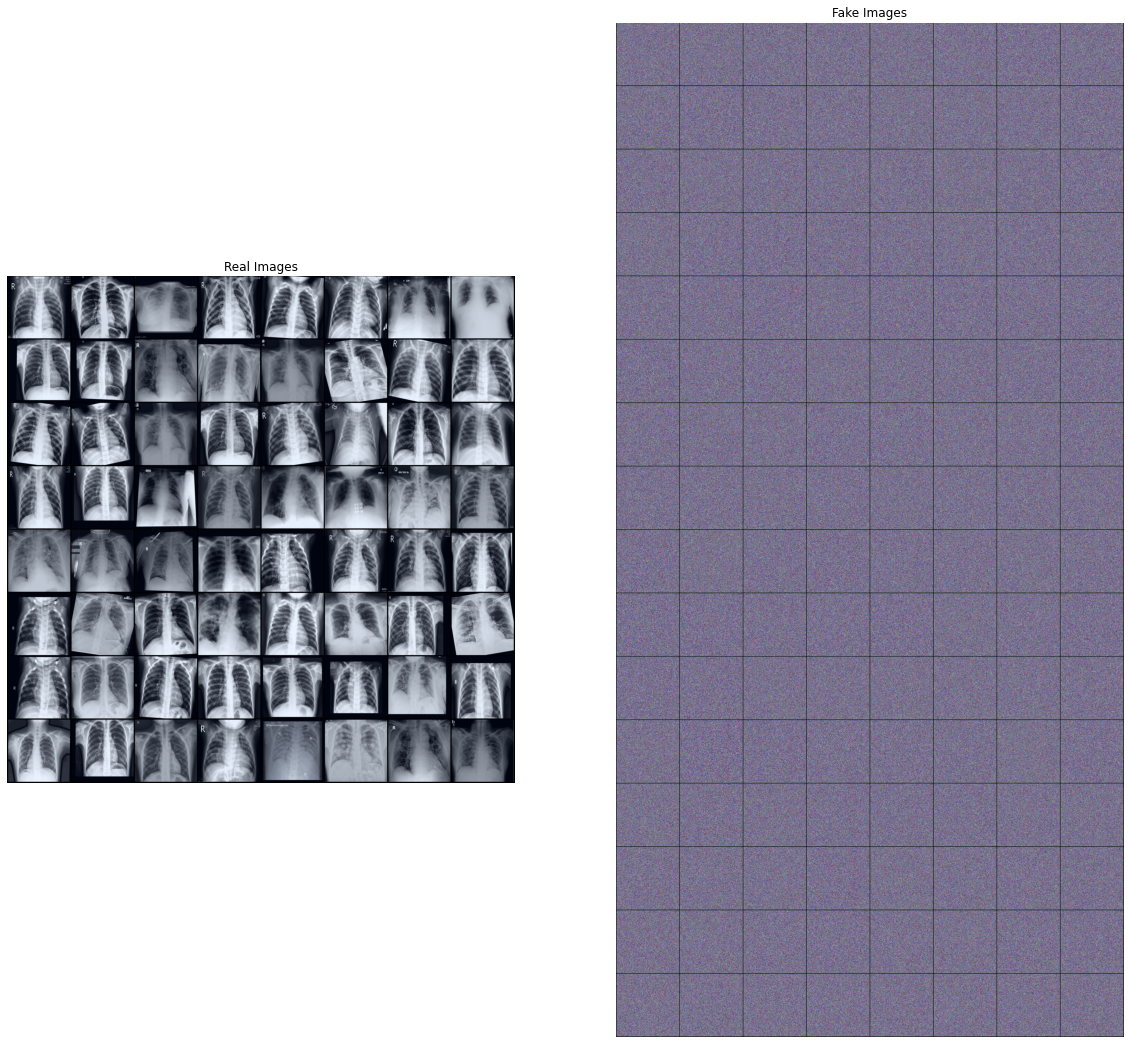

In [12]:
test_gan(acgan)

In [13]:
def plot_gan(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    plt.show()
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [14]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['G_losses'][-1]
    d_losses = metrics['D_losses'][-1]
    path='GANAug/plots/ACGAN/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H-%M-%S"))
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)
    plot_gan('G_losses', num_epochs, metrics['G_losses'], path, True)
    plot_gan('D_losses', num_epochs, metrics['D_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('G_class_losses', num_epochs, metrics['G_class_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('D_class_losses', num_epochs, metrics['D_class_losses'], path, True)
    plot_gan('D_syn_losses', num_epochs, metrics['D_syn_losses'], path, True)
    plot_gan('Losses', num_epochs, metrics['Losses'], path, True)

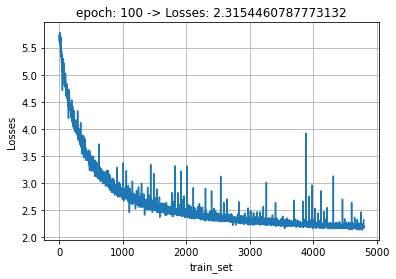

In [15]:
save_model(acgan.generator, acgan.discriminator, acgan.optimizer_g, acgan.optimizer_d, acgan.metrics, acgan.num_epoch)

Discriminator s tensor([[0.3366],
        [0.3306],
        [0.5420],
        [0.4696],
        [0.6162],
        [0.5750],
        [0.5012],
        [0.5963],
        [0.6474],
        [0.4329],
        [0.3758],
        [0.3996],
        [0.4696],
        [0.4643],
        [0.5326],
        [0.5798],
        [0.5964],
        [0.2775],
        [0.4659],
        [0.4572],
        [0.3586],
        [0.4427],
        [0.5035],
        [0.5236],
        [0.6513],
        [0.5696],
        [0.3970],
        [0.5827],
        [0.5003],
        [0.4394],
        [0.5004],
        [0.6200],
        [0.5096],
        [0.4504],
        [0.3691],
        [0.3526],
        [0.4785],
        [0.4249],
        [0.4023],
        [0.4974],
        [0.4667],
        [0.5152],
        [0.5265],
        [0.3719],
        [0.4351],
        [0.6031],
        [0.3235],
        [0.4612],
        [0.4209],
        [0.5060],
        [0.3116],
        [0.4256],
        [0.4638],
        [0.5024],
        [0.3

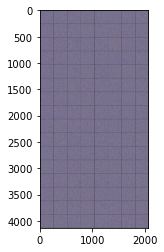

In [16]:
test_img_list = []
test_noise = torch.randn(acgan.batch_size, acgan.size_of_z, device=device)
test_label = torch.randn(acgan.batch_size, acgan.num_of_label, device=device)
test_img = acgan.generator(test_noise, test_label)

s_output, c_label_op = acgan.discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))

class label for real tensor([2, 0, 0, 2, 1, 2, 0, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1,
        0, 0, 2, 0, 1, 1, 1, 1, 1, 0, 0, 1, 2, 2, 1, 1, 0, 2, 0, 2, 0, 1, 2, 0,
        0, 2, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 0, 1,
        1, 0, 1, 1, 1, 2, 1, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 2,
        1, 2, 2, 0, 2, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 2, 1, 0, 1, 0, 2, 0, 0, 0,
        0, 0, 1, 2, 0, 2, 1, 1])
Discriminator s tensor([[0.4795],
        [0.5822],
        [0.5467],
        [0.4377],
        [0.6055],
        [0.4642],
        [0.4933],
        [0.5484],
        [0.4940],
        [0.5692],
        [0.6092],
        [0.4823],
        [0.3988],
        [0.3119],
        [0.5226],
        [0.4653],
        [0.3737],
        [0.4595],
        [0.7921],
        [0.5463],
        [0.5141],
        [0.3575],
        [0.4480],
        [0.5773],
        [0.5649],
        [0.5415],
        [0.4210],
        [0.5333],
        [0.5169],
        

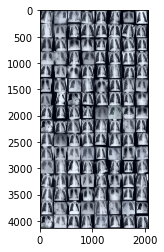

In [17]:
data = next(iter(acgan.test_loader))
test_noise, test_class_lable = data
test_img = test_noise
print('class label for real', test_class_lable)

s_output,c_label_op = acgan.discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))